In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing.imputation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from scipy.stats import reciprocal, uniform
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
    
from sklearn.metrics import classification_report,accuracy_score, log_loss, roc_curve, auc,r2_score,mean_squared_error
%matplotlib inline

In [2]:
df_train = pd.read_csv('CA_Crime_Rate_Train.csv')
df_test = pd.read_csv('CA_Crime_Rate_Test.csv')
df_dict = pd.read_csv('CA_Crime_Rate_Data_Dictionary.csv')

In [3]:
df_train.isnull().sum(axis = 0).sort_values(ascending=False).head()


Percent RACE  - Native Hawaiian and Other Pacific Islander    248
Percent; GROSS RENT - $1,000 to $1,499                        136
Percent; GROSS RENT - Less than $200                          136
Percent; GROSS RENT - $200 to $299                            136
Percent; GROSS RENT - $300 to $499                            136
dtype: int64

In [4]:


def impute_from_city(df, city_df):
    #for each city
    for i, row in df.iterrows():
        #getting number of rows for City
        other_rows = city_df.loc[row["City"]]["Count"]
        if other_rows > 1:
            # list of rows for this city
            roi = [x for x in list(df.index[df.City == row.City]) if x != i]
            # get row in df with same city but not same index 
            other_row = df.iloc[roi[0]]
            df.iloc[i] = row.fillna(other_row)
        else:
            print("One row for " + row["City"])
    return df
        
def print_rate_descriptions(df):
    print(df.describe()["Robbery_rate"])
    print(df.describe()["Property_crime_rate"])
    print(df.describe()["Burglary_rate"])
    print(df.describe()["Larceny_theft_rate"])
    print(df.describe()["Motor_vehicle_theft_rate"])
    
def impute_values(df):
    # strategy can be changed to "median" and “most_frequent”
    cities = df["City"]
    df = df.drop('City', axis=1)
    #cannot impute city
    cols = df.columns
    print(cols)
    imputer = Imputer(missing_values='NaN', strategy='mean')
    print(df.shape)
    df = pd.DataFrame(imputer.fit_transform(df.values), columns=cols)
    df["City"] = cities
    return df

def plot_vs_2(X_name ,y_name, df):
    
    xd = df[X_name].values
    yd = df[y_name].values
    # sort the data
    reorder = sorted(range(len(xd)), key = lambda ii: xd[ii])
    xd = [xd[ii] for ii in reorder]
    yd = [yd[ii] for ii in reorder]
    
    plt.figure(figsize=(10,8))
    # make the scatter plot
    plt.scatter(xd, yd, s=30, alpha=0.5, marker='o')
   
    # determine best fit line
    par = np.polyfit(xd, yd, 1, full=True)

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(.9*max(xd)+.1*min(xd),.9*max(yd)+.1*min(yd),'$R^2 = %0.2f$'% Rsqr, fontsize=30)
    plt.xlabel(X_name)
    plt.ylabel(y_name)

    # error bounds
    yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)]
    par = np.polyfit(xd, yerr, 2, full=True)

    yerrUpper = [(xx*slope+intercept)+(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]
    yerrLower = [(xx*slope+intercept)-(par[0][0]*xx**2 + par[0][1]*xx + par[0][2]) for xx,yy in zip(xd,yd)]

    plt.plot(xl, yl, '-r')
    plt.plot(xd, yerrLower, '--r')
    plt.plot(xd, yerrUpper, '--r')
    plt.show()


def plot_vs(X_name ,y_name, df):
    x = df[X_name]
    y = df[y_name]
    plt.figure(figsize=(10,8))
    plt.scatter(x,y, alpha=0.5)
    plt.title(X_name + " vs " + y_name)
    plt.xlabel(X_name)
    plt.ylabel(y_name)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.show()

### Dataset general info

In [5]:
df_train.info( null_counts=1)
# from df_train.info() there is one object - assuming this is the city name
# all of the features are numeric except city 
# property_crime_rate, Larceny_crime_rate, total_law_enforcement_employees,total_officers,total_civilians,employment_status, occupation, industry, percentage of familu,housing occupancy rental vacancy rate, missing a lot for rent and race...  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Columns: 120 entries, City to percentage_ Total: - 4-or-more-person household:
dtypes: float64(114), int64(5), object(1)
memory usage: 472.6+ KB


In [6]:
print("Train size: ",df_train.shape)
print("Test size: ", df_test.shape)

Train size:  (504, 120)
Test size:  (88, 120)


In [7]:
city_df_train = pd.DataFrame(df_train.groupby(['City']).size())
city_df_train = city_df_train.rename(columns={'City': 'City', 0: 'Count'})

city_df_test = pd.DataFrame(df_test.groupby(['City']).size())
city_df_test = city_df_test.rename(columns={'City': 'City', 0: 'Count'})

In [8]:
df_train = impute_from_city(df_train, city_df_train)
df_test = impute_from_city(df_test, city_df_test)

One row for City59
One row for City83
One row for City91
One row for City99
One row for City105
One row for City118
One row for City120
One row for City124
One row for City125
One row for City148
One row for City188
One row for City189
One row for City203
One row for City206
One row for City214
One row for City240
One row for City248
One row for City269
One row for City287
One row for City288


In [9]:
df_train.isnull().sum(axis = 0).sort_values(ascending=False).head()

Percent; GROSS RENT - $1,500 or more    115
Percent; GROSS RENT - Less than $200    115
Percent; GROSS RENT - $200 to $299      115
Percent; GROSS RENT - $300 to $499      115
Percent; GROSS RENT - $500 to $749      115
dtype: int64

In [10]:
df_temp = df_train.dropna(how="any", axis=0) # any value equal to NA for a row
print("Train size with dropna(any): ",df_temp.shape)
# lose 3/5ths of the data by dropping these columns so I should impute them
# do any columns have ALL values missing
df_temp = df_train.dropna(how="all", axis=0)
print("Train size with dropna(all): " ,df_temp.shape)
# no rows are completely empty


Train size with dropna(any):  (376, 120)
Train size with dropna(all):  (504, 120)


In [11]:
# 50/120 columns are missing data 
#df_train.loc[:, df_train.isnull().any()]
#df_train["Property_crime_rate"] >= (df_train["Robbery_rate"]+df_train["Larceny_theft_rate"]+df_train["Motor_vehicle_theft_rate"])

In [12]:
# full_cols = df_train.dropna(axis=1)
# for i, row in pd.DataFrame(df_train.isnull().sum(axis = 0)).iterrows():
#     print(row[0])
#     if row[0] > 0:
#         #this column becomes target
#         #get indices of target that are not missing
#         #get corresponding x rows from full_cols for this
#         #missing y values becomes test set to predict values for
#         y = 
    


In [13]:
df_train.isnull().sum(axis = 0).head()

City                   0
Year                   0
Robbery_rate           0
Property_crime_rate    0
Burglary_rate          0
dtype: int64

In [14]:
print_rate_descriptions(df_train)

count    504.000000
mean     174.216865
std      145.068378
min        0.000000
25%       63.900000
50%      138.050000
75%      228.300000
max      739.500000
Name: Robbery_rate, dtype: float64
count     504.000000
mean     3795.142857
std      1522.279042
min       210.700000
25%      2623.800000
50%      3509.250000
75%      4813.275000
max      8730.100000
Name: Property_crime_rate, dtype: float64
count     504.000000
mean      859.891468
std       491.452388
min        51.400000
25%       489.000000
50%       756.150000
75%      1112.550000
max      2773.800000
Name: Burglary_rate, dtype: float64
count     504.000000
mean     2545.221627
std      1016.312968
min       149.000000
25%      1761.225000
50%      2362.150000
75%      3211.225000
max      5958.500000
Name: Larceny_theft_rate, dtype: float64
count     504.000000
mean      390.622619
std       292.667286
min         6.200000
25%       165.550000
50%       301.750000
75%       536.600000
max      1777.000000
Name: Motor_ve

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


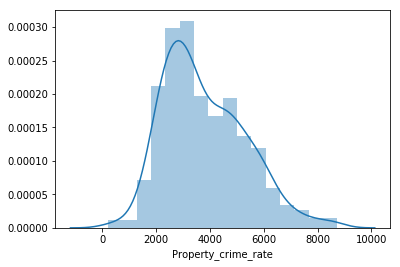

In [15]:
sns.distplot(df_train['Property_crime_rate'])

In [16]:
# pass df train and test to impute

df_test = impute_values(df_test.drop(columns=["Robbery_rate",'Property_crime_rate', 'Burglary_rate','Larceny_theft_rate', 'Motor_vehicle_theft_rate' ]))

Index(['Year', 'Population', 'Total law_enforcement_employees',
       'Law_enforcement_Total officers emloyee', 'Total civilians employee',
       'Percent; SEX AND AGE - Male', 'Percent; SEX AND AGE - Female',
       'Percent; SEX AND AGE - Under 5 years',
       'Percent; SEX AND AGE - 5 to 9 years',
       'Percent; SEX AND AGE - 10 to 14 years',
       ...
       'Percent of houdsehold with children under 18; AGE OF OWN CHILDREN - Under 6 years and 6 to 17 years',
       'Percent of houdsehold with children under 18; AGE OF OWN CHILDREN - 6 to 17 years only',
       'Civilian employed population 16 years and over - Government workers',
       'Civilian employed population 16 years and over - Private wage and salary workers',
       'Civilian employed population 16 years and over - Self-employed workers in own not incorporated business',
       'Civilian employed population 16 years and over - Unpaid family workers',
       'percentage_ Total: - 1-person household:',
       'percen

In [17]:
df_train = impute_values(df_train)

Index(['Year', 'Robbery_rate', 'Property_crime_rate', 'Burglary_rate',
       'Larceny_theft_rate', 'Motor_vehicle_theft_rate', 'Population',
       'Total law_enforcement_employees',
       'Law_enforcement_Total officers emloyee', 'Total civilians employee',
       ...
       'Percent of houdsehold with children under 18; AGE OF OWN CHILDREN - Under 6 years and 6 to 17 years',
       'Percent of houdsehold with children under 18; AGE OF OWN CHILDREN - 6 to 17 years only',
       'Civilian employed population 16 years and over - Government workers',
       'Civilian employed population 16 years and over - Private wage and salary workers',
       'Civilian employed population 16 years and over - Self-employed workers in own not incorporated business',
       'Civilian employed population 16 years and over - Unpaid family workers',
       'percentage_ Total: - 1-person household:',
       'percentage_ Total: - 2-person household:',
       'percentage_ Total: - 3-person household:',
    

In [18]:
#nans(df_train).head()

In [19]:
df_train_recent = df_train[df_train["Year"]==2]

In [20]:
list(df_train_recent.columns)

['Year',
 'Robbery_rate',
 'Property_crime_rate',
 'Burglary_rate',
 'Larceny_theft_rate',
 'Motor_vehicle_theft_rate',
 'Population',
 'Total law_enforcement_employees',
 'Law_enforcement_Total officers emloyee',
 'Total civilians employee',
 'Percent; SEX AND AGE - Male',
 'Percent; SEX AND AGE - Female',
 'Percent; SEX AND AGE - Under 5 years',
 'Percent; SEX AND AGE - 5 to 9 years',
 'Percent; SEX AND AGE - 10 to 14 years',
 'Percent; SEX AND AGE - 15 to 19 years',
 'Percent; SEX AND AGE - 20 to 24 years',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; SEX AND AGE - 35 to 44 years',
 'Percent; SEX AND AGE - 45 to 54 years',
 'Percent; SEX AND AGE - 55 to 59 years',
 'Percent; SEX AND AGE - 60 to 64 years',
 'Percent; SEX AND AGE - 65 to 74 years',
 'Percent; SEX AND AGE - 75 to 84 years',
 'Percent; SEX AND AGE - 85 years and over',
 'Estimate; SEX AND AGE - Median age (years)',
 'Percent; EMPLOYMENT STATUS - In labor force',
 'Percent; OCCUPATION - Management, business, scie

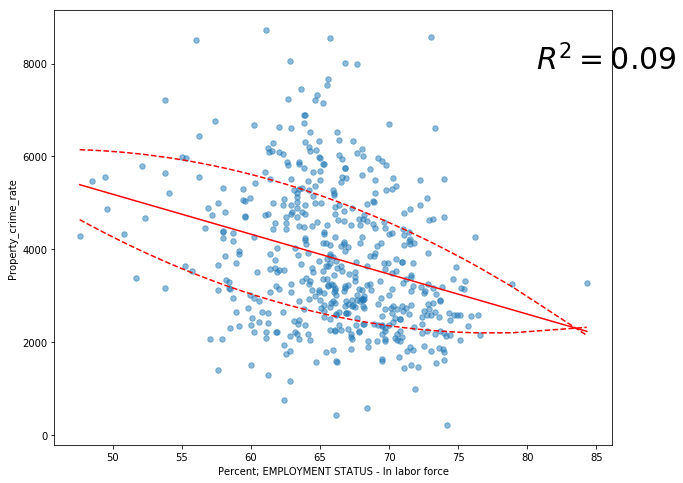

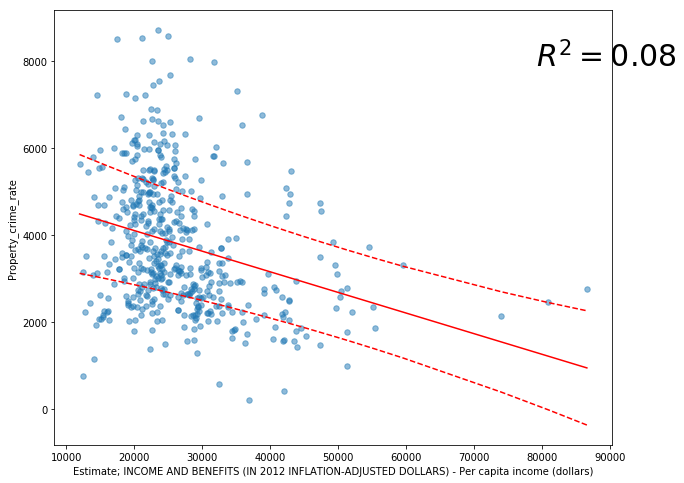

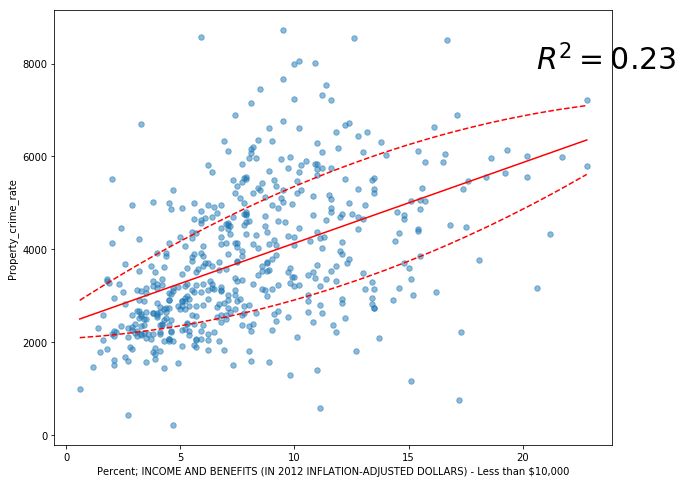

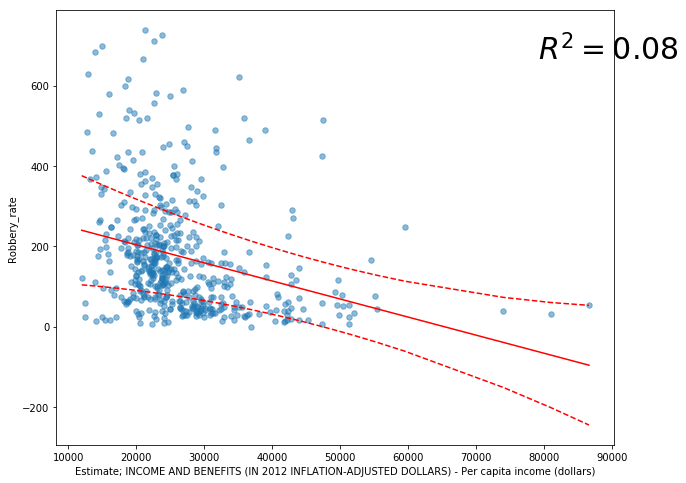

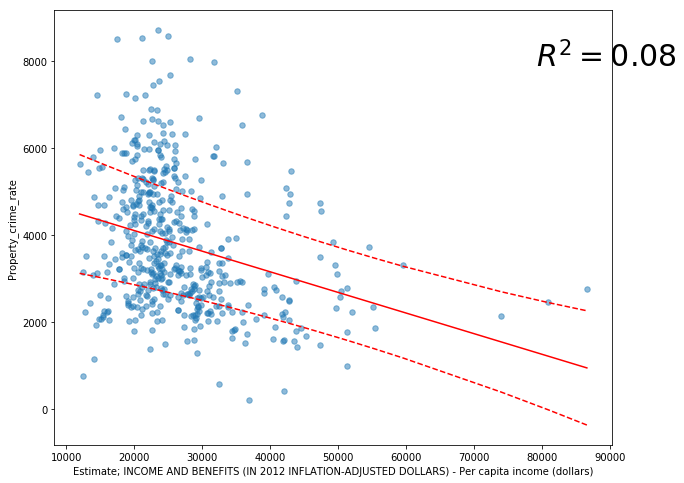

In [90]:
plot_vs_2('Percent; EMPLOYMENT STATUS - In labor force','Property_crime_rate',df_train)
plot_vs_2('Estimate; INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)','Property_crime_rate',df_train)
plot_vs_2("Percent; INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS) - Less than $10,000","Property_crime_rate",df_train)
plot_vs_2('Estimate; INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)','Robbery_rate',df_train)
plot_vs_2( 'Estimate; INCOME AND BENEFITS (IN 2012 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)',"Property_crime_rate",df_train)


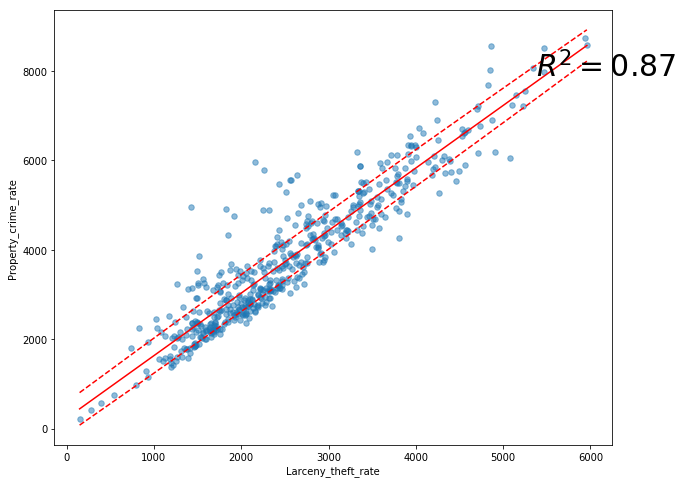

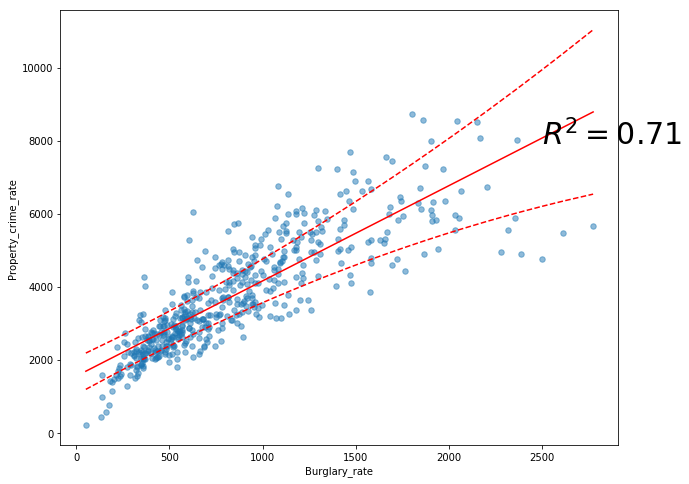

In [87]:
plot_vs_2( 'Larceny_theft_rate',"Property_crime_rate",df_train)
plot_vs_2( 'Burglary_rate',"Property_crime_rate",df_train)
plot_vs_2( 'Larceny_theft_rate',"Robbery_rate",df_train)
plot_vs_2( 'Burglary_rate',"Property_crime_rate",df_train)

In [22]:
scaler = StandardScaler()

In [69]:
X = df_train.drop(columns=['Robbery_rate','Property_crime_rate','Burglary_rate',
                           'Larceny_theft_rate','Motor_vehicle_theft_rate','City']).values
y = df_train['Property_crime_rate'].values
#X = scaler.fit_transform(X,y)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42)

In [25]:
model2 = SVR(kernel='rbf') #,gamma= 0.001,C=1000,verbose=True)#,gamma=0.02,epsilon=0.001, C=1000, verbose=True)
%time model2.fit(X_train, y_train)

Wall time: 15 ms


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
y_pred = model2.predict(X_train)
print("Train")
print("R^2: ",round(r2_score(y_train, y_pred),4))
print("MSE: ",round(mean_squared_error(y_pred, y_train),4))
y_pred_test = model2.predict(X_test)
print("Test")
print("R^2: ",round(r2_score(y_test, y_pred_test),4))
print("MSE: ",round(mean_squared_error(y_pred_test, y_test),4))
#744237

Train
R^2:  -0.0288
MSE:  2618091.8138
Test
R^2:  -0.032
MSE:  2284217.113


In [71]:
model3 = SVR(kernel='rbf',C=1000)
%time model3.fit(X_train, y_train)

Wall time: 18.9 ms


SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [72]:
y_pred = model3.predict(X_train)
print("Train")
print("R^2: ",round(r2_score(y_train, y_pred),4))
print("MSE: ",round(mean_squared_error(y_pred, y_train),4))
y_pred_test = model3.predict(X_test)
print("Test")
print("R^2: ",round(r2_score(y_test, y_pred_test),4))
print("MSE: ",round(mean_squared_error(y_pred_test, y_test),4))

Train
R^2:  0.6481
MSE:  895453.6127
Test
R^2:  -0.0225
MSE:  2263290.6344


In [73]:
X = scaler.fit_transform(X,y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42)

In [76]:
model4 = SVR(kernel='rbf',C=1000)
%time model4.fit(X_train, y_train)

Wall time: 17 ms


SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [77]:
y_pred = model4.predict(X_train)
print("Train")
print("R^2: ",round(r2_score(y_train, y_pred),4))
print("MSE: ",round(mean_squared_error(y_pred, y_train),4))
y_pred_test = model4.predict(X_test)
print("Test")
print("R^2: ",round(r2_score(y_test, y_pred_test),4))
print("MSE: ",round(mean_squared_error(y_pred_test, y_test),4))

Train
R^2:  0.7382
MSE:  666260.0587
Test
R^2:  0.4861
MSE:  1137586.0277


In [82]:
modelfinal = SVR(kernel='linear',C=10)
%time modelfinal.fit(X_train, y_train)

Wall time: 13.9 ms


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [83]:
y_pred = modelfinal.predict(X_train)
print("Train")
print("R^2: ",round(r2_score(y_train, y_pred),4))
print("MSE: ",round(mean_squared_error(y_pred, y_train),4))
y_pred_test = modelfinal.predict(X_test)
print("Test")
print("R^2: ",round(r2_score(y_test, y_pred_test),4))
print("MSE: ",round(mean_squared_error(y_pred_test, y_test),4))
#590306

Train
R^2:  0.6277
MSE:  947301.3764
Test
R^2:  0.383
MSE:  1365801.2983


In [78]:

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': ['auto',1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [79]:
scores = ['r2','neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVR(), tuned_parameters, cv=5,
                       scoring= score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()



# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

-0.067 (+/-0.123) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
-0.068 (+/-0.123) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-0.069 (+/-0.123) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
-0.042 (+/-0.120) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
-0.058 (+/-0.124) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
-0.068 (+/-0.123) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.123 (+/-0.120) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.038 (+/-0.130) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
-0.056 (+/-0.126) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.371 (+/-0.138) for {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
0.332 (+/-0.210) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.051 (+/-0.131) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.260 (+/-0.197) for {'C': 1, 'kernel': 'linear'}
0.423 (+/-0.325)

In [ ]:
plt.figure(figsize=(20,20))
plt.matshow(df_train_recent.corr(),fignum=1)
plt.show()

In [ ]:
vals = f_regression(X, y, center=True)

In [ ]:
df_f_regression = pd.DataFrame({"Feature": df_train.drop(columns=['Robbery_rate','Property_crime_rate','Burglary_rate','Larceny_theft_rate','Motor_vehicle_theft_rate','City']).columns,"F":vals[0],"p-value":vals[1]})

In [ ]:
kbest = SelectKBest(f_regression, k='all')
result = kbest.fit_transform(X, y)

In [88]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_train.drop(columns=["City"]), 200))

Top Absolute Correlations
Percent; HOUSING OCCUPANCY - Occupied housing units                                                             Percent; HOUSING OCCUPANCY - Vacant housing units                                                                          1.000000
Percent; HOUSING TENURE - Owner-occupied                                                                        Percent; HOUSING TENURE - Renter-occupied                                                                                  1.000000
Percent; SEX AND AGE - Male                                                                                     Percent; SEX AND AGE - Female                                                                                              1.000000
Total law_enforcement_employees                                                                                 Law_enforcement_Total officers emloyee                                                                                     0.99427

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X, y)
reg.score(X, y)
y_pred = reg.predict(X)
print(r2_score(y, y_pred))
print(mean_squared_error(y_pred, y))